<a href="https://colab.research.google.com/github/edluyuan/HISVAE/blob/main/HISVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, transforms
from torchvision.datasets import MovingMNIST
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
# Fetching the dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 4748138.41it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 133709.32it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1280096.46it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2360952.88it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
class VAE(nn.Module):
    def __init__(self, input_dim=784, latent_dim=2):
        super(VAE, self).__init__()
        # Encoder setup
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, latent_dim * 2)  # Outputs for both mu and log_var
        )

        # Decoder setup
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Sigmoid()  # Ensures the output is between 0 and 1
        )

    def encode(self, x):
        h = self.encoder(x.view(-1, 784))
        mu, log_var = h.chunk(2, dim=-1)  # Split the output into mu and log_var
        return mu, log_var

    def reparameterize(self, mu, log_var):
        # Standard reparameterization technique
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def decode(self, z):
        # Decoding step
        return self.decoder(z)

    def forward(self, x):
        # Forward pass through the network
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

    def loss_function(self, recon_x, x, mu, log_var):
        # Reconstruction loss (binary cross-entropy)
        BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

        # KL divergence loss
        KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

        # Total loss
        return BCE + KLD

In [4]:
vae = VAE()
optimizer = optim.Adam(vae.parameters(), lr=0.001)
def trainVAE(model, optimizer, train_loader, tolerance=1e-3, max_epochs=1000):
    model.to(device)
    model.train()
    last_loss = float('inf')
    epoch = 0
    patience = 10      # Patience for early stopping
    patience_counter = 0  # Counter to keep track of epochs without improvement

    while epoch < max_epochs:
        train_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, log_var = model(data)
            loss = model.loss_function(recon_batch, data, mu, log_var)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

            if batch_idx % 100 == 0:
                current_batch = batch_idx * len(data)
                percentage_completed = 100. * batch_idx / len(train_loader)
                print(f'Train Epoch: {epoch + 1} [{current_batch}/{len(train_loader.dataset)} ({percentage_completed:.0f}%)]\tLoss: {loss.item() / len(data):.6f}')

        average_loss = train_loss / len(train_loader.dataset)
        print(f'====> Epoch: {epoch + 1} Average loss: {average_loss:.4f}')

        # Check for convergence
        if abs(last_loss - average_loss) < tolerance:
            print("Convergence reached.")
            break

        # Early stopping check
        if average_loss < last_loss:
            last_loss = average_loss
            patience_counter = 0  # Reset patience counter
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

        last_loss = average_loss
        epoch += 1
trainVAE(vae, optimizer, train_loader)


Train Epoch: 1 [0/60000 (0%)]	Loss: 554.772034
Train Epoch: 1 [6400/60000 (11%)]	Loss: 186.486298
Train Epoch: 1 [12800/60000 (21%)]	Loss: 171.503006
Train Epoch: 1 [19200/60000 (32%)]	Loss: 183.098633
Train Epoch: 1 [25600/60000 (43%)]	Loss: 164.220261
Train Epoch: 1 [32000/60000 (53%)]	Loss: 159.528259
Train Epoch: 1 [38400/60000 (64%)]	Loss: 172.842377
Train Epoch: 1 [44800/60000 (75%)]	Loss: 165.134827
Train Epoch: 1 [51200/60000 (85%)]	Loss: 167.252823
Train Epoch: 1 [57600/60000 (96%)]	Loss: 161.151413
====> Epoch: 1 Average loss: 176.0627
Train Epoch: 2 [0/60000 (0%)]	Loss: 160.219330
Train Epoch: 2 [6400/60000 (11%)]	Loss: 160.217590
Train Epoch: 2 [12800/60000 (21%)]	Loss: 176.316742
Train Epoch: 2 [19200/60000 (32%)]	Loss: 166.127228
Train Epoch: 2 [25600/60000 (43%)]	Loss: 180.435913
Train Epoch: 2 [32000/60000 (53%)]	Loss: 153.670471
Train Epoch: 2 [38400/60000 (64%)]	Loss: 175.884338
Train Epoch: 2 [44800/60000 (75%)]	Loss: 171.383575
Train Epoch: 2 [51200/60000 (85%)]	Los

In [10]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from scipy.special import logsumexp

from tqdm import tqdm
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, mean_squared_error
from scipy.stats import mode, norm

from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import seaborn as sns


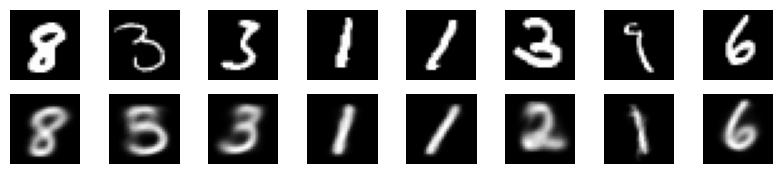

In [7]:
def visualize_reconstruction(model, data):
    model.eval()
    with torch.no_grad():
        data = data.to(device)
        recon, _, _ = model(data)
        data = data.cpu()
        recon = recon.cpu()
        num_images = 8
        fig, axs = plt.subplots(2, num_images, figsize=(10, 2))
        for i in range(num_images):
            axs[0, i].imshow(data[i].reshape(28, 28), cmap='gray')
            axs[0, i].axis('off')
            axs[1, i].imshow(recon[i].reshape(28, 28), cmap='gray')
            axs[1, i].axis('off')
        plt.show()

data, _ = next(iter(train_loader))
visualize_reconstruction(vae, data)

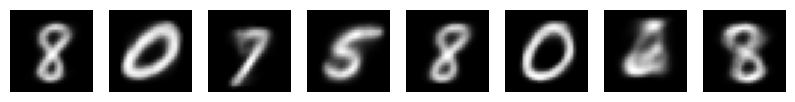

In [8]:
def visualize_random_samples(model):
    with torch.no_grad():
        z = torch.randn(8, 2).to(device)
        samples = model.decoder(z).cpu()
        plt.figure(figsize=(10, 2))
        for i in range(8):
            plt.subplot(1, 8, i + 1)
            plt.imshow(samples[i].reshape(28, 28), cmap='gray')
            plt.axis('off')
        plt.show()

visualize_random_samples(vae)

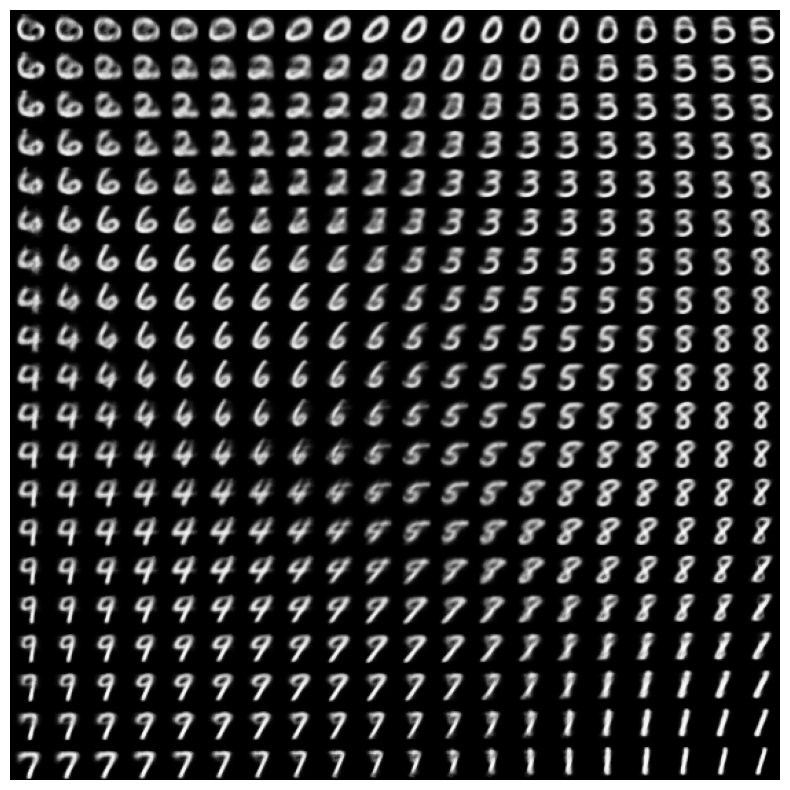

In [11]:
vae.eval()  # Set the model to evaluation mode

# Visualization parameters
samples_per_dim = 20
digit_size = 28

# Prepare the grid of latent variables
grid_x = norm.ppf(np.linspace(0.05, 0.95, samples_per_dim))
grid_y = norm.ppf(np.linspace(0.05, 0.95, samples_per_dim))

figure = np.zeros((digit_size * samples_per_dim,
                   digit_size * samples_per_dim))

for i, xi in enumerate(grid_x):
    for j, yi in enumerate(grid_y):
        # Transform the grid points to tensor and decode
        z_sample = torch.tensor([[xi, yi]], dtype=torch.float32)
        z_sample = z_sample.to(next(vae.parameters()).device)  # Ensure the sample is on the correct device
        x_decoded = vae.decoder(z_sample)
        x_decoded = x_decoded.cpu().detach().numpy()  # Convert back to numpy from tensor
        digit = x_decoded.reshape(digit_size, digit_size)
        figure[j * digit_size: (j + 1) * digit_size,
               i * digit_size: (i + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.axis('off')  # Hide axes to focus only on the generated digits
plt.show()

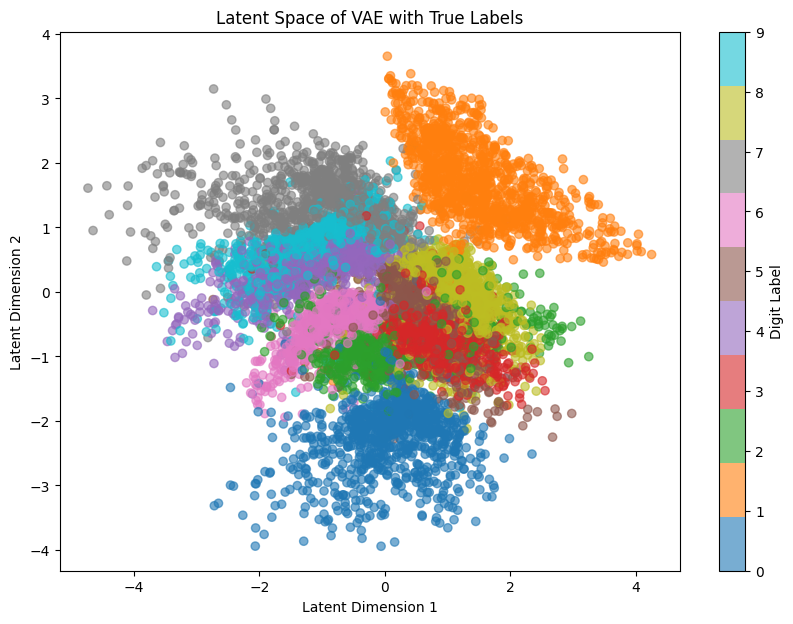

In [12]:
def extract_latent_variables_and_labels(loader, model):
    model.eval()
    latents = []
    labels = []
    with torch.no_grad():
        for batch, label in loader:
            batch = batch.to(next(model.parameters()).device)  # Move data to device
            output = model.encoder(batch.view(-1, 784))  # Process batch
            mu = output[0] if isinstance(output, tuple) else output  # Extract mu, checking output type
            latents.append(mu.cpu().numpy())  # Convert mu to numpy and store
            labels.append(label.cpu().numpy())  # Store labels
    latents = np.concatenate(latents, axis=0)
    labels = np.concatenate(labels)
    return latents, labels

latent_variables, true_labels = extract_latent_variables_and_labels(test_loader, vae)


plt.figure(figsize=(10, 7))
scatter = plt.scatter(latent_variables[:, 0], latent_variables[:, 1], c=true_labels, cmap='tab10', alpha=0.6)
plt.colorbar(scatter, label='Digit Label', ticks=range(10))
plt.title('Latent Space of VAE with True Labels')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.show()

In [13]:
class BetaVAE(nn.Module):
    def __init__(self, input_dim=784, latent_dim=2):
        super(BetaVAE, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, latent_dim * 2)  # Outputs for both mu and log_var
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Sigmoid()  # Ensures the output is between 0 and 1
        )

    def encode(self, x):
        h = self.encoder(x.view(-1, self.input_dim))
        mu, log_var = h.chunk(2, dim=-1)  # Split the output into mu and log_var
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

    def loss_function(self, recon_x, x, mu, log_var, beta=1.0):
        BCE = F.binary_cross_entropy(recon_x, x.view(-1, self.input_dim), reduction='sum')
        KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        return BCE + beta * KLD


In [14]:
beta_vae = BetaVAE()
optimizer = optim.Adam(beta_vae.parameters(), lr=0.001)

def trainBetaVAE(model, optimizer, train_loader, beta=1.0, tolerance=0.001, max_epochs=1000):
    model.train()
    last_loss = float('inf')
    epoch = 0

    while epoch < max_epochs:
        train_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(next(model.parameters()).device)
            optimizer.zero_grad()
            recon_batch, mu, log_var = model(data)
            loss = model.loss_function(recon_batch, data, mu, log_var, beta)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

            if batch_idx % 100 == 0:
                current_batch = batch_idx * len(data)
                percentage_completed = 100. * batch_idx / len(train_loader)
                print(f'Train Epoch: {epoch + 1} [{current_batch}/{len(train_loader.dataset)} ({percentage_completed:.0f}%)]\tLoss: {loss.item() / len(data):.6f}')

        average_loss = train_loss / len(train_loader.dataset)
        print(f'====> Epoch: {epoch + 1} Average loss: {average_loss:.4f}')

        # Check for convergence
        if abs(last_loss - average_loss) < tolerance:
            print("Convergence reached.")
            break
        last_loss = average_loss
        epoch += 1

trainBetaVAE(beta_vae, optimizer, train_loader, beta=5.0)

Train Epoch: 1 [0/60000 (0%)]	Loss: 552.167725
Train Epoch: 1 [6400/60000 (11%)]	Loss: 205.092987
Train Epoch: 1 [12800/60000 (21%)]	Loss: 196.562775
Train Epoch: 1 [19200/60000 (32%)]	Loss: 198.892105
Train Epoch: 1 [25600/60000 (43%)]	Loss: 184.480453
Train Epoch: 1 [32000/60000 (53%)]	Loss: 176.307861
Train Epoch: 1 [38400/60000 (64%)]	Loss: 183.020721
Train Epoch: 1 [44800/60000 (75%)]	Loss: 188.509644
Train Epoch: 1 [51200/60000 (85%)]	Loss: 176.984802
Train Epoch: 1 [57600/60000 (96%)]	Loss: 182.785095
====> Epoch: 1 Average loss: 191.3422
Train Epoch: 2 [0/60000 (0%)]	Loss: 188.686386
Train Epoch: 2 [6400/60000 (11%)]	Loss: 179.141129
Train Epoch: 2 [12800/60000 (21%)]	Loss: 180.690231
Train Epoch: 2 [19200/60000 (32%)]	Loss: 176.962692
Train Epoch: 2 [25600/60000 (43%)]	Loss: 181.737152
Train Epoch: 2 [32000/60000 (53%)]	Loss: 177.457718
Train Epoch: 2 [38400/60000 (64%)]	Loss: 170.554367
Train Epoch: 2 [44800/60000 (75%)]	Loss: 180.722809
Train Epoch: 2 [51200/60000 (85%)]	Los

In [19]:
print(device)

cuda


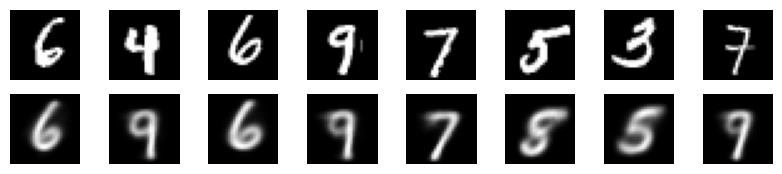

In [20]:



def visualize_reconstruction(model, data):
    model.to(device)
    model.eval()
    with torch.no_grad():
        data = data.to(device)
        recon, _, _ = model(data)
        data = data.cpu()
        recon = recon.cpu()
        num_images = 8
        fig, axs = plt.subplots(2, num_images, figsize=(10, 2))
        for i in range(num_images):
            axs[0, i].imshow(data[i].reshape(28, 28), cmap='gray')
            axs[0, i].axis('off')
            axs[1, i].imshow(recon[i].reshape(28, 28), cmap='gray')
            axs[1, i].axis('off')
        plt.show()

data, _ = next(iter(train_loader))

visualize_reconstruction(beta_vae, data)

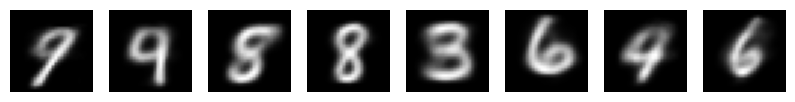

In [21]:
visualize_random_samples(beta_vae)

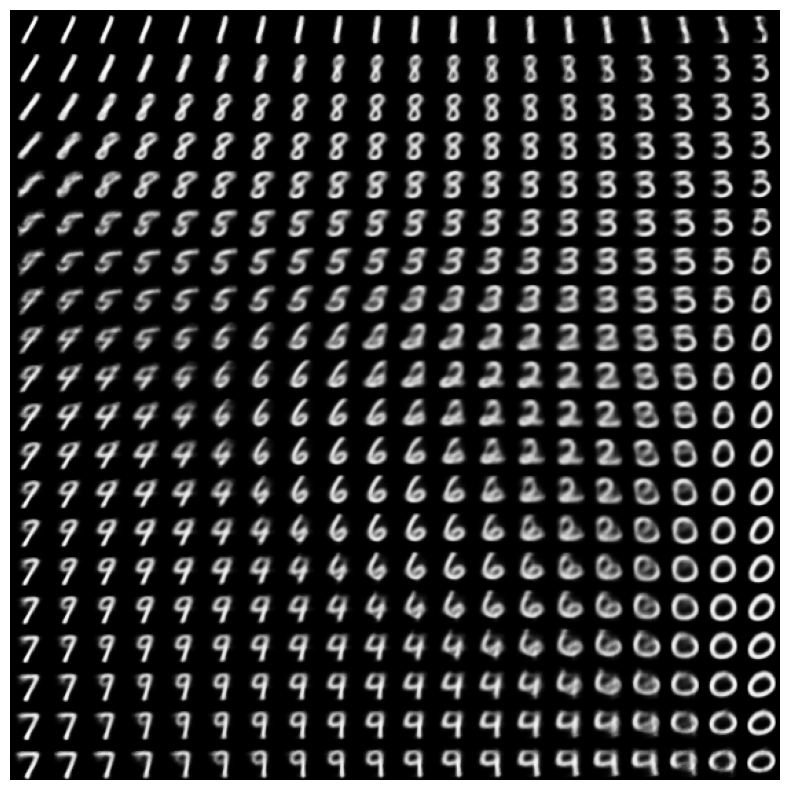

In [22]:
beta_vae.eval()  # Set the model to evaluation mode

# Visualization parameters
samples_per_dim = 20
digit_size = 28

# Prepare the grid of latent variables
grid_x = norm.ppf(np.linspace(0.05, 0.95, samples_per_dim))
grid_y = norm.ppf(np.linspace(0.05, 0.95, samples_per_dim))

figure = np.zeros((digit_size * samples_per_dim,
                   digit_size * samples_per_dim))

for i, xi in enumerate(grid_x):
    for j, yi in enumerate(grid_y):
        # Transform the grid points to tensor and decode
        z_sample = torch.tensor([[xi, yi]], dtype=torch.float32)
        z_sample = z_sample.to(next(beta_vae.parameters()).device)  # Ensure the sample is on the correct device
        x_decoded = beta_vae.decoder(z_sample)
        x_decoded = x_decoded.cpu().detach().numpy()  # Convert back to numpy from tensor
        digit = x_decoded.reshape(digit_size, digit_size)
        figure[j * digit_size: (j + 1) * digit_size,
               i * digit_size: (i + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.axis('off')  # Hide axes to focus only on the generated digits
plt.show()

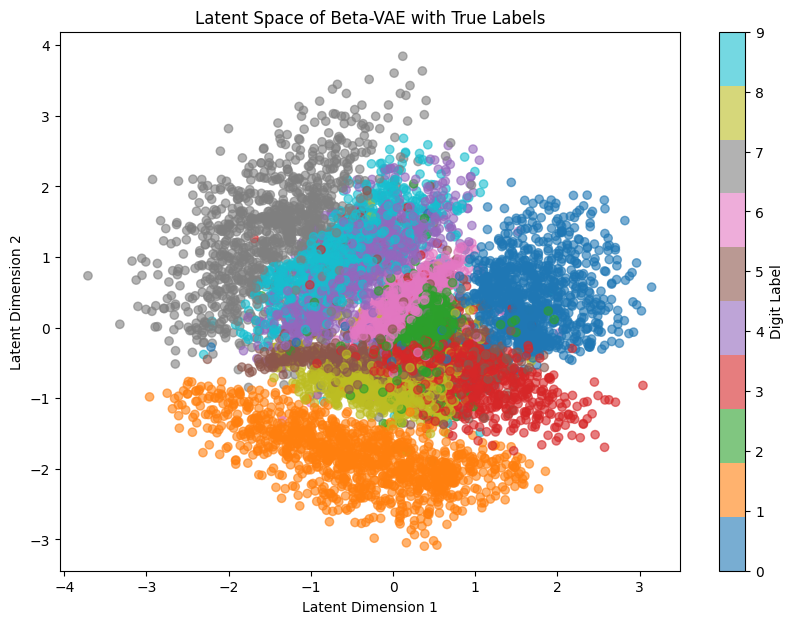

In [23]:
def extract_latent_variables_and_labels(loader, model):
    model.eval()
    latents = []
    labels = []
    with torch.no_grad():
        for batch, label in loader:
            batch = batch.to(next(model.parameters()).device)  # Move data to device
            output = model.encoder(batch.view(-1, 784))  # Process batch
            mu = output[0] if isinstance(output, tuple) else output  # Extract mu, checking output type
            latents.append(mu.cpu().numpy())  # Convert mu to numpy and store
            labels.append(label.cpu().numpy())  # Store labels
    latents = np.concatenate(latents, axis=0)
    labels = np.concatenate(labels)
    return latents, labels

latent_variables, true_labels = extract_latent_variables_and_labels(test_loader, beta_vae)


plt.figure(figsize=(10, 7))
scatter = plt.scatter(latent_variables[:, 0], latent_variables[:, 1], c=true_labels, cmap='tab10', alpha=0.6)
plt.colorbar(scatter, label='Digit Label', ticks=range(10))
plt.title('Latent Space of Beta-VAE with True Labels')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.show()

In [24]:
class HMCVAE(nn.Module):
    def __init__(self, input_dim=784, latent_dim=2):
        super(HMCVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, latent_dim*2)  # mu and log_var
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x.view(-1, 784))
        mu, log_var = h.chunk(2, dim=-1)
        return mu, log_var

    def decode(self, z):
        return self.decoder(z)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def forward(self, x):
        h = self.encoder(x.view(-1, 784))
        mu, log_var = h.chunk(2, dim=-1)
        z = self.reparameterize(mu, log_var)
        return self.decoder(z), mu, log_var, z

    def hamiltonian(self, z, mu, log_var):
        kinetic = torch.sum(0.5 * z ** 2, dim=1)
        potential = torch.sum(0.5 * ((z - mu) / torch.exp(log_var)) ** 2, dim=1)
        return kinetic + potential

In [25]:
def hva_loss(reconstructed_x, x, mu, log_var, z, beta=1.0):
    # Reconstruction loss
    BCE = nn.functional.binary_cross_entropy(reconstructed_x, x.view(-1, 784), reduction='sum')
    # Hamiltonian as a regularizer
    H = hmcvae.hamiltonian(z, mu, log_var)
    return BCE + beta * torch.mean(H)

In [26]:
hmcvae = HMCVAE()
optimizer = optim.Adam(hmcvae.parameters(), lr=0.001)

def trainHMCVAE():
    hmcvae.train()
    last_loss = float('inf')
    epoch = 0
    tolerance = 0.001  # Threshold for convergence, adjust as necessary
    max_epochs = 1000   # Optional: Set a maximum number of epochs to prevent endless training

    while epoch < max_epochs:
        train_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            optimizer.zero_grad()
            recon_batch, mu, log_var, z = hmcvae(data)
            loss = hva_loss(recon_batch, data, mu, log_var, z)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
            if batch_idx % 100 == 0:
                print(f'Train Epoch: {epoch + 1} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')

        average_loss = train_loss / len(train_loader.dataset)
        print(f'====> Epoch: {epoch + 1} Average loss: {average_loss:.4f}')

        # Check for convergence
        if abs(last_loss - average_loss) < tolerance:
            print("Convergence reached.")
            break
        last_loss = average_loss
        epoch += 1

# Now call the function
trainHMCVAE()

Train Epoch: 1 [0/60000 (0%)]	Loss: 548.527405
Train Epoch: 1 [6400/60000 (11%)]	Loss: 174.337540
Train Epoch: 1 [12800/60000 (21%)]	Loss: 175.032883
Train Epoch: 1 [19200/60000 (32%)]	Loss: 173.386017
Train Epoch: 1 [25600/60000 (43%)]	Loss: 168.679779
Train Epoch: 1 [32000/60000 (53%)]	Loss: 166.648773
Train Epoch: 1 [38400/60000 (64%)]	Loss: 159.749756
Train Epoch: 1 [44800/60000 (75%)]	Loss: 174.242661
Train Epoch: 1 [51200/60000 (85%)]	Loss: 165.201584
Train Epoch: 1 [57600/60000 (96%)]	Loss: 154.270569
====> Epoch: 1 Average loss: 170.3852
Train Epoch: 2 [0/60000 (0%)]	Loss: 159.427185
Train Epoch: 2 [6400/60000 (11%)]	Loss: 169.875809
Train Epoch: 2 [12800/60000 (21%)]	Loss: 155.336914
Train Epoch: 2 [19200/60000 (32%)]	Loss: 164.066223
Train Epoch: 2 [25600/60000 (43%)]	Loss: 150.955399
Train Epoch: 2 [32000/60000 (53%)]	Loss: 175.064255
Train Epoch: 2 [38400/60000 (64%)]	Loss: 157.936234
Train Epoch: 2 [44800/60000 (75%)]	Loss: 155.175537
Train Epoch: 2 [51200/60000 (85%)]	Los

In [27]:
class HISVAE(nn.Module):
    def __init__(self, input_dim=784, latent_dim=2):
        super(HISVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, latent_dim*2)  # Outputs mu and log_var
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x.view(-1, 784))
        mu, log_var = h.chunk(2, dim=-1)
        mu = torch.clamp(mu, min=-10, max=10)
        log_var = torch.clamp(log_var, min=-10, max=10)
        return mu, log_var

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        gen = self.decode(z)
        return gen, mu, log_var, z

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def hamiltonian(self, z, p, mu, log_var):
        kinetic = torch.sum(p**2, dim=1) / 2
        potential = torch.sum(0.5 * ((z - mu) / torch.exp(0.5 * log_var))**2, dim=1)
        return kinetic + potential

    def leapfrog(self, z, p, mu, log_var, step_size=0.001, n_steps=10):
        z, p = z.clone(), p.clone()
        for _ in range(n_steps):
            p -= step_size / 2 * self.grad_potential(z, mu, log_var)  # half step momentum update
            z += step_size * p  # full step position update
            p -= step_size / 2 * self.grad_potential(z, mu, log_var)  # half step momentum update
        return z, p

    def grad_potential(self, z, mu, log_var):
        return (z - mu) / torch.exp(log_var)

In [28]:
def hva_his_loss(reconstructed_x, x, mu, log_var, z, p, model, beta=1.0):
    # Standard VAE reconstruction loss
    reconstructed_x = reconstructed_x.clamp(0, 1)
    BCE = F.binary_cross_entropy(reconstructed_x, x.view(-1, 784), reduction='sum')

    # Calculate the Hamiltonian for initial and evolved states
    initial_hamiltonian = model.hamiltonian(z, p, mu, log_var)
    z_new, p_new = model.leapfrog(z, p, mu, log_var)
    final_hamiltonian = model.hamiltonian(z_new, p_new, mu, log_var)

    # Compute importance weights and incorporate them into the loss
    weights = torch.exp(initial_hamiltonian - final_hamiltonian)
    weighted_BCE = weights * BCE  # Apply importance weighting to the reconstruction loss

    return torch.mean(weighted_BCE)

In [63]:
hisvae = HISVAE()
optimizer = optim.Adam(hisvae.parameters(), lr=0.001)

def trainHISVAE(model, optimizer, train_loader, val_loader):
    model.train()
    best_val_loss = float('inf')
    epochs_no_improve = 0
    max_epochs = 1000
    epoch = 0
    patience = 10  # Number of epochs to wait for improvement before stopping the training

    while epoch < max_epochs and epochs_no_improve < patience:
        model.train()
        train_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(next(model.parameters()).device)
            optimizer.zero_grad()
            recon_batch, mu, log_var, z = model(data)
            p = torch.randn_like(z)  # Sample initial momenta for HIS
            loss = hva_his_loss(recon_batch, data, mu, log_var, z, p, model)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

            if batch_idx % 100 == 0:
                print(f'Train Epoch: {epoch + 1} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, _ in val_loader:
                data = data.to(next(model.parameters()).device)
                recon_batch, mu, log_var, z = model(data)
                p = torch.randn_like(z)
                loss = hva_his_loss(recon_batch, data, mu, log_var, z, p, model)
                val_loss += loss.item()

        val_loss /= len(val_loader.dataset)
        print(f'====> Epoch: {epoch + 1} Validation loss: {val_loss:.4f}')

        # Check if validation loss improved
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f'No improvement in validation loss for {epochs_no_improve} epoch(s)')

        # Check for early stopping
        if epochs_no_improve >= patience:
            print("Early stopping triggered due to no improvement in validation loss.")
            break

        epoch += 1

trainHISVAE(hisvae, optimizer, train_loader, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 550.278442
Train Epoch: 1 [6400/60000 (11%)]	Loss: 173.268387
Train Epoch: 1 [12800/60000 (21%)]	Loss: 168.166534
Train Epoch: 1 [19200/60000 (32%)]	Loss: 159.086807
Train Epoch: 1 [25600/60000 (43%)]	Loss: 166.558441
Train Epoch: 1 [32000/60000 (53%)]	Loss: 162.177963
Train Epoch: 1 [38400/60000 (64%)]	Loss: 167.603256
Train Epoch: 1 [44800/60000 (75%)]	Loss: 159.425613
Train Epoch: 1 [51200/60000 (85%)]	Loss: 156.670868
Train Epoch: 1 [57600/60000 (96%)]	Loss: 160.995285
====> Epoch: 1 Validation loss: 161.3063
Train Epoch: 2 [0/60000 (0%)]	Loss: 160.228622
Train Epoch: 2 [6400/60000 (11%)]	Loss: 174.097488
Train Epoch: 2 [12800/60000 (21%)]	Loss: 154.450668
Train Epoch: 2 [19200/60000 (32%)]	Loss: 161.807556
Train Epoch: 2 [25600/60000 (43%)]	Loss: 151.982727
Train Epoch: 2 [32000/60000 (53%)]	Loss: 150.288269
Train Epoch: 2 [38400/60000 (64%)]	Loss: 159.823074
Train Epoch: 2 [44800/60000 (75%)]	Loss: 156.994202
Train Epoch: 2 [51200/60000 (85%)]	

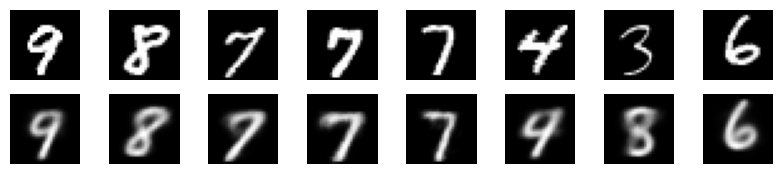

In [64]:
def visualize_reconstruction(model, data):
    model.eval()
    with torch.no_grad():
        data = data.to(device)
        recon, _, _, _ = model(data)
        data = data.cpu()
        recon = recon.cpu()
        num_images = 8
        fig, axs = plt.subplots(2, num_images, figsize=(10, 2))
        for i in range(num_images):
            axs[0, i].imshow(data[i].reshape(28, 28), cmap='gray')
            axs[0, i].axis('off')
            axs[1, i].imshow(recon[i].reshape(28, 28), cmap='gray')
            axs[1, i].axis('off')
        plt.show()

data, _ = next(iter(train_loader))
visualize_reconstruction(hmcvae, data)

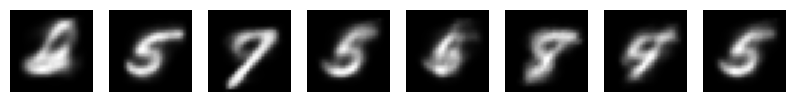

In [65]:
def visualize_random_samples(model):
    with torch.no_grad():
        z = torch.randn(8, 2).to(device)
        samples = model.decoder(z).cpu()
        plt.figure(figsize=(10, 2))
        for i in range(8):
            plt.subplot(1, 8, i + 1)
            plt.imshow(samples[i].reshape(28, 28), cmap='gray')
            plt.axis('off')
        plt.show()

visualize_random_samples(hmcvae)

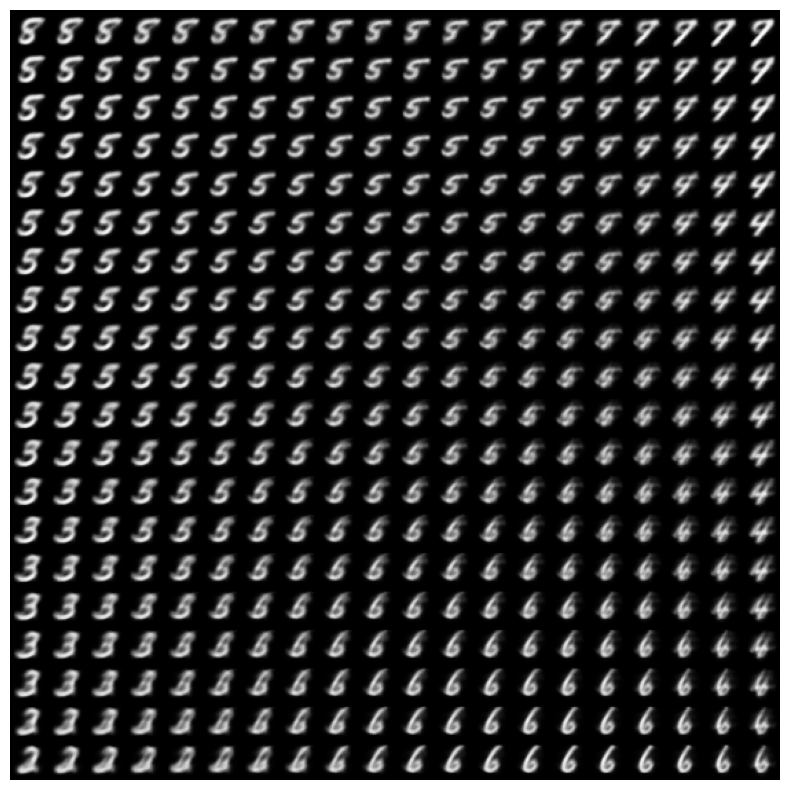

In [66]:
hmcvae.eval()  # Set the model to evaluation mode

# Visualization parameters
samples_per_dim = 20
digit_size = 28

# Prepare the grid of latent variables
grid_x = norm.ppf(np.linspace(0.05, 0.95, samples_per_dim))
grid_y = norm.ppf(np.linspace(0.05, 0.95, samples_per_dim))

figure = np.zeros((digit_size * samples_per_dim,
                   digit_size * samples_per_dim))

for i, xi in enumerate(grid_x):
    for j, yi in enumerate(grid_y):
        # Transform the grid points to tensor and decode
        z_sample = torch.tensor([[xi, yi]], dtype=torch.float32)
        z_sample = z_sample.to(next(hmcvae.parameters()).device)  # Ensure the sample is on the correct device
        x_decoded = hmcvae.decoder(z_sample)
        x_decoded = x_decoded.cpu().detach().numpy()  # Convert back to numpy from tensor
        digit = x_decoded.reshape(digit_size, digit_size)
        figure[j * digit_size: (j + 1) * digit_size,
               i * digit_size: (i + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.axis('off')  # Hide axes to focus only on the generated digits
plt.show()

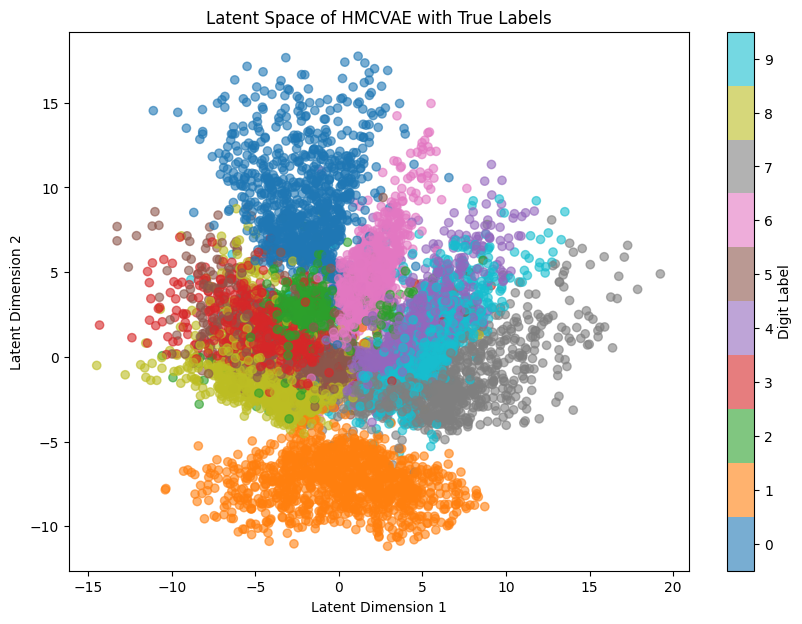

In [67]:

# Step 1: Extract latent variables
def extract_latent_variables_and_labels(loader, model):
    model.eval()
    latents = []
    labels = []
    with torch.no_grad():
        for batch, label in loader:
            batch = batch.to(next(model.parameters()).device)  # Move data to device
            output = model.encoder(batch.view(-1, 784))  # Process batch
            mu = output[0] if isinstance(output, tuple) else output  # Extract mu, checking output type
            latents.append(mu.cpu().numpy())  # Convert mu to numpy and store
            labels.append(label.cpu().numpy())  # Store labels
    latents = np.concatenate(latents, axis=0)
    labels = np.concatenate(labels)
    return latents, labels

latent_variables, true_labels = extract_latent_variables_and_labels(test_loader, hmcvae)


plt.figure(figsize=(10, 7))
scatter = plt.scatter(latent_variables[:, 0], latent_variables[:, 1], c=true_labels, cmap='tab10', alpha=0.6)
plt.colorbar(scatter, label='Digit Label', ticks=range(10))
plt.clim(-0.5, 9.5)  # Adjust the color limits to center ticks on integers
plt.title('Latent Space of HMCVAE with True Labels')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.show()

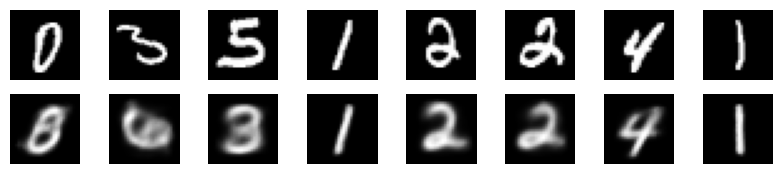

In [36]:
hisvae.to(device)
def visualize_reconstruction(model, data):
    model.eval()
    with torch.no_grad():
        data = data.to(device)
        recon, _, _, _ = model(data)
        data = data.cpu()
        recon = recon.cpu()
        num_images = 8
        fig, axs = plt.subplots(2, num_images, figsize=(10, 2))
        for i in range(num_images):
            axs[0, i].imshow(data[i].reshape(28, 28), cmap='gray')
            axs[0, i].axis('off')
            axs[1, i].imshow(recon[i].reshape(28, 28), cmap='gray')
            axs[1, i].axis('off')
        plt.show()

data, _ = next(iter(train_loader))
visualize_reconstruction(hisvae, data)

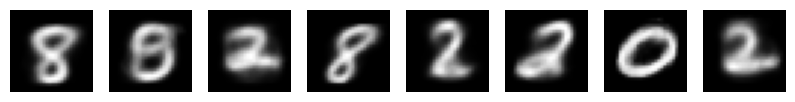

In [37]:
def visualize_random_samples(model):
    with torch.no_grad():
        z = torch.randn(8, 2).to(device)
        samples = model.decoder(z).cpu()
        plt.figure(figsize=(10, 2))
        for i in range(8):
            plt.subplot(1, 8, i + 1)
            plt.imshow(samples[i].reshape(28, 28), cmap='gray')
            plt.axis('off')
        plt.show()

visualize_random_samples(hisvae)

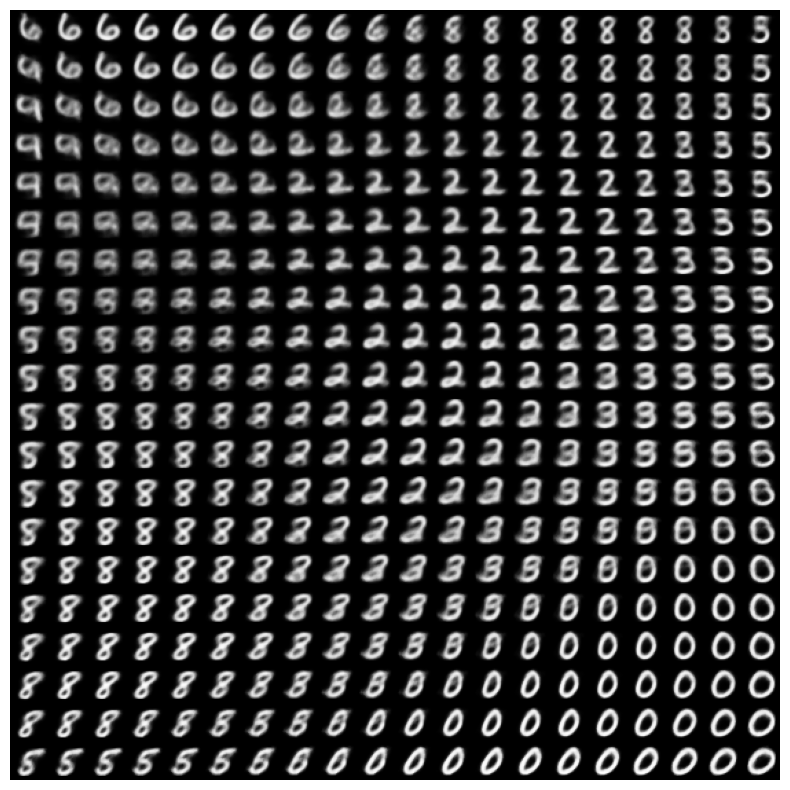

In [38]:

hisvae.eval()  # Set the model to evaluation mode

# Visualization parameters
samples_per_dim = 20
digit_size = 28

# Prepare the grid of latent variables
grid_x = norm.ppf(np.linspace(0.05, 0.95, samples_per_dim))
grid_y = norm.ppf(np.linspace(0.05, 0.95, samples_per_dim))

figure = np.zeros((digit_size * samples_per_dim,
                   digit_size * samples_per_dim))

for i, xi in enumerate(grid_x):
    for j, yi in enumerate(grid_y):
        # Transform the grid points to tensor and decode
        z_sample = torch.tensor([[xi, yi]], dtype=torch.float32)
        z_sample = z_sample.to(next(hisvae.parameters()).device)  # Ensure the sample is on the correct device
        x_decoded = hisvae.decoder(z_sample)
        x_decoded = x_decoded.cpu().detach().numpy()  # Convert back to numpy from tensor
        digit = x_decoded.reshape(digit_size, digit_size)
        figure[j * digit_size: (j + 1) * digit_size,
               i * digit_size: (i + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.axis('off')  # Hide axes to focus only on the generated digits
plt.show()

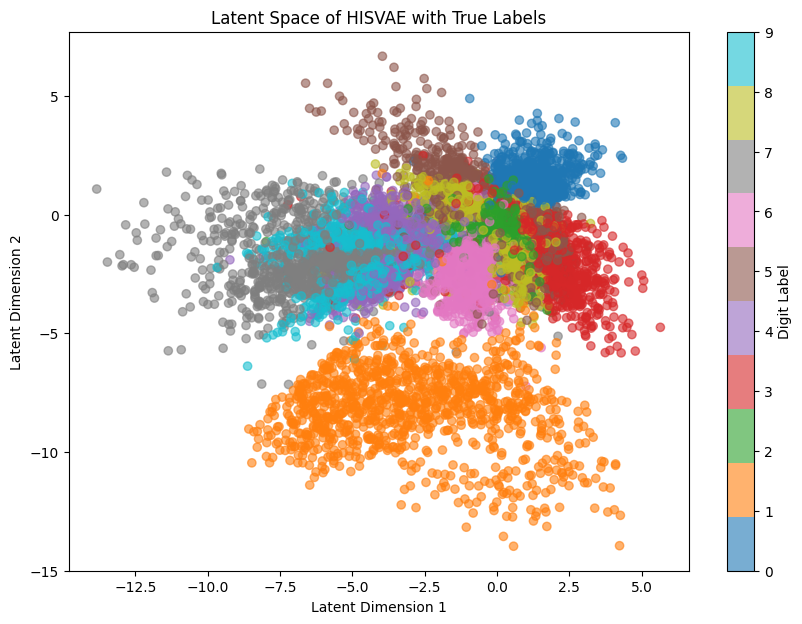

In [39]:
def extract_latent_variables_and_labels(loader, model):
    model.eval()
    latents = []
    labels = []
    with torch.no_grad():
        for batch, label in loader:
            batch = batch.to(next(model.parameters()).device)  # Move data to device
            output = model.encoder(batch.view(-1, 784))  # Process batch
            mu = output[0] if isinstance(output, tuple) else output  # Extract mu, checking output type
            latents.append(mu.cpu().numpy())  # Convert mu to numpy and store
            labels.append(label.cpu().numpy())  # Store labels
    latents = np.concatenate(latents, axis=0)
    labels = np.concatenate(labels)
    return latents, labels

latent_variables, true_labels = extract_latent_variables_and_labels(test_loader, hisvae)


plt.figure(figsize=(10, 7))
scatter = plt.scatter(latent_variables[:, 0], latent_variables[:, 1], c=true_labels, cmap='tab10', alpha=0.6)
plt.colorbar(scatter, label='Digit Label', ticks=range(10))
plt.title('Latent Space of HISVAE with True Labels')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.show()

In [40]:
def calculate_bce_loss(reconstructed_x, x):
    """ Binary Cross Entropy loss for reconstruction. """
    return F.binary_cross_entropy(reconstructed_x, x.view(-1, 784), reduction='sum')
def calculate_kl_divergence(mu, log_var):
    """ KL divergence loss calculation. """
    return -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
def calculate_his_elbo(reconstructed_x, x, mu, log_var, z, p, model):
    """ Calculate a modified ELBO for HISVAE. """
    initial_hamiltonian = model.hamiltonian(z, p, mu, log_var)
    z_new, p_new = model.leapfrog(z, p, mu, log_var)
    final_hamiltonian = model.hamiltonian(z_new, p_new, mu, log_var)
    bce = calculate_bce_loss(reconstructed_x, x)
    delta_hamiltonian = initial_hamiltonian - final_hamiltonian
    return -bce + torch.mean(delta_hamiltonian)  # HIS-modified ELBO
def calculate_nll(his_elbo):
    """ Negative log likelihood estimated by negative ELBO (since ELBO is a lower bound on NLL). """
    return -his_elbo.mean()
def evaluate_hisvae(model, data_loader):
    model.eval()  # Ensure the model is in evaluation mode
    total_bce, total_elbo, total_nll = 0.0, 0.0, 0.0
    with torch.no_grad():  # No gradients needed
        for data, _ in data_loader:
            data = data.to(next(model.parameters()).device)
            recon_batch, mu, log_var, z = model(data)
            p = torch.randn_like(z)  # Sample initial momenta for HIS

            # Calculate metrics
            bce = calculate_bce_loss(recon_batch, data)
            his_elbo = calculate_his_elbo(recon_batch, data, mu, log_var, z, p, model)
            nll = calculate_nll(his_elbo)

            total_bce += bce.item()
            total_elbo += his_elbo.item()
            total_nll += nll.item()

    # Averaging over all batches
    num_samples = len(data_loader.dataset)
    average_bce = total_bce / num_samples
    average_elbo = total_elbo / num_samples
    average_nll = total_nll / num_samples

    print(f"Average BCE: {average_bce:.4f}, Average HIS-ELBO: {average_elbo:.4f}, Average NLL: {average_nll:.4f}")
    model.train()  # Reset to training mode if needed later

In [41]:
evaluate_hisvae(hisvae, test_loader)

Average BCE: 139.9550, Average HIS-ELBO: -139.9550, Average NLL: 139.9550


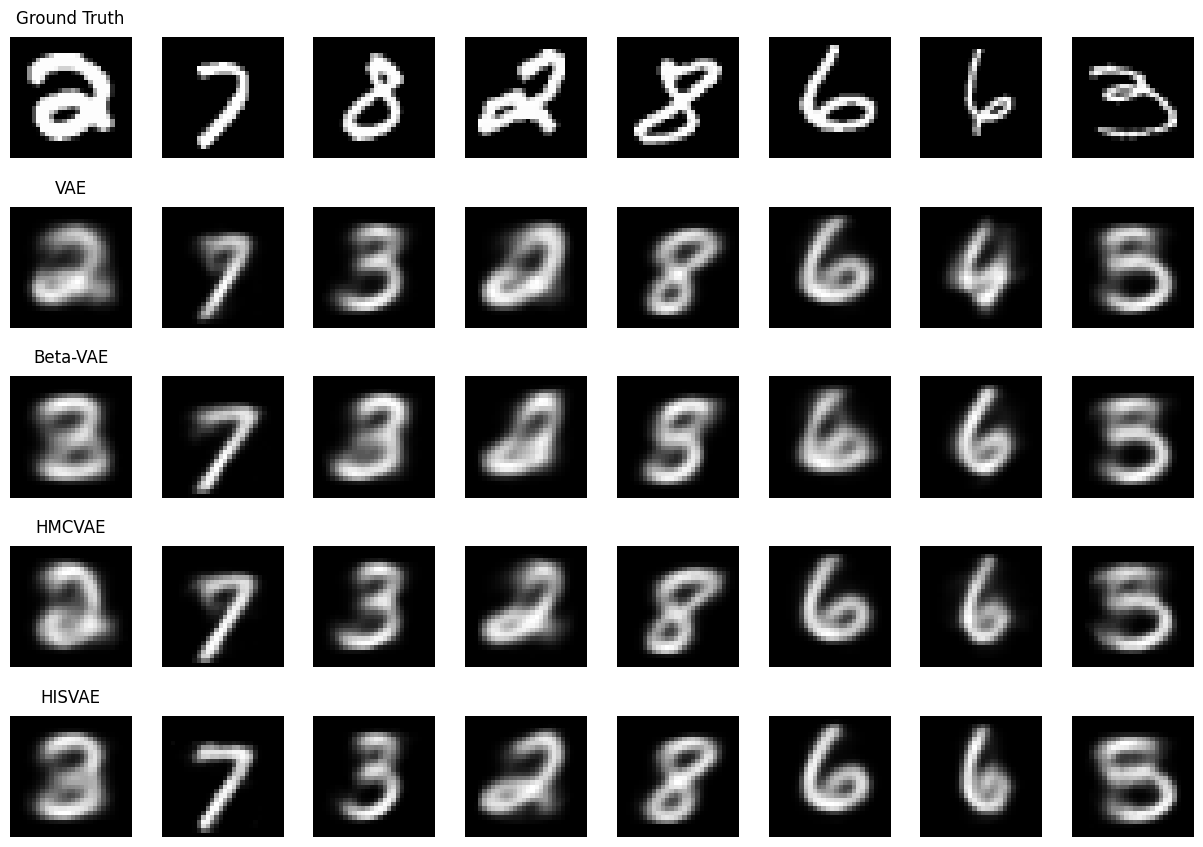

In [53]:
def visualize_all_reconstructions(models, data, device):
    """
    Visualize original and reconstructed images from multiple VAE models in a single figure,
    with titles for each row indicating the model or the data type (e.g., Ground Truth).

    Parameters:
    - models: A dictionary of model instances with their names as keys.
    - data: The input data for reconstruction visualization.
    - device: The device (CPU or GPU) the data should be processed on.
    """
    num_images = 8  # Number of images to display
    total_rows = len(models) + 1  # One row for original + one for each model
    fig, axs = plt.subplots(total_rows, num_images, figsize=(15, 2 * total_rows))
    data = data.to(device)  # Move data to the specified device

    # Display original images in the first row
    data_cpu = data.cpu()  # Move data back to CPU for visualization
    for i in range(num_images):
        axs[0, i].imshow(data_cpu[i].reshape(28, 28), cmap='gray')
        axs[0, i].axis('off')
    axs[0, 0].set_title('Ground Truth', fontsize=12, pad=10)  # Title for the first row

    # Iterate over each model and display reconstructions
    for idx, (model_name, model) in enumerate(models.items(), 1):
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():  # Turn off gradients for the following code block
            outputs = model(data)  # Obtain all outputs
            recon = outputs[0]  # Assume the first output is the reconstruction
            recon = recon.cpu()  # Move reconstructions back to CPU for visualization

            for i in range(num_images):
                axs[idx, i].imshow(recon[i].reshape(28, 28), cmap='gray')
                axs[idx, i].axis('off')
            axs[idx, 0].set_title(model_name, fontsize=12, pad=10)  # Title for each model row

    # Adjust layout to ensure titles and images are aligned properly
    fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, hspace=0.4, wspace=0.1)
    plt.show()

# Example usage with models dictionary and device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
models = {
    "VAE": vae,
    "Beta-VAE": beta_vae,
    "HMCVAE": hmcvae,
    "HISVAE": hisvae
}
data, _ = next(iter(train_loader))

visualize_all_reconstructions(models, data, device)

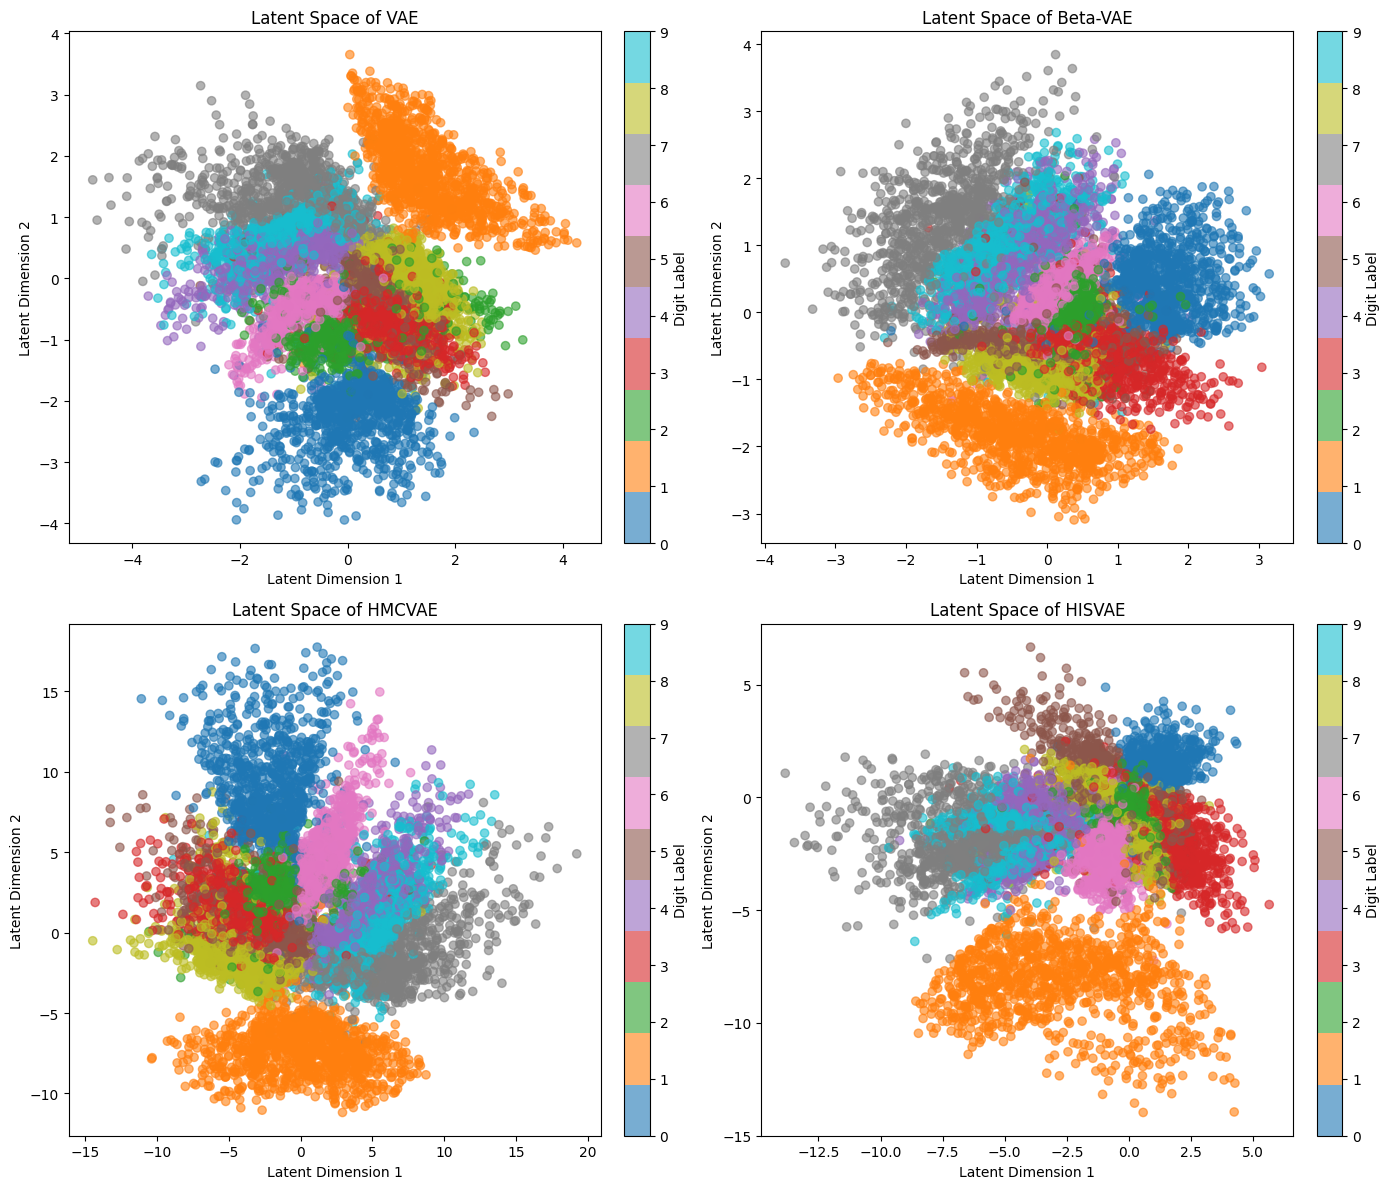

In [55]:
def visualize_latent_spaces(models, loader, device):
    """
    Visualize the latent spaces of multiple VAE models in a 2x2 grid, each with its own digit label colorbar.

    Parameters:
    - models: Dictionary of model instances with their names as keys.
    - loader: DataLoader for the dataset to visualize.
    - device: The device (CPU or GPU) the data should be processed on.
    """
    fig, axs = plt.subplots(2, 2, figsize=(14, 12))  # Set up a 2x2 grid of plots

    for idx, (model_name, model) in enumerate(models.items()):
        ax = axs[idx // 2, idx % 2]  # Locate the right subplot
        model.eval()
        latents = []
        labels = []
        with torch.no_grad():
            for batch, label in loader:
                batch = batch.to(device)
                output = model.encoder(batch.view(-1, 784))
                mu = output[0] if isinstance(output, tuple) else output
                latents.append(mu.cpu().numpy())
                labels.append(label.cpu().numpy())

        latents = np.concatenate(latents, axis=0)
        labels = np.concatenate(labels)

        # Scatter plot of latent variables
        scatter = ax.scatter(latents[:, 0], latents[:, 1], c=labels, cmap='tab10', alpha=0.6)
        ax.set_title(f'Latent Space of {model_name}')
        ax.set_xlabel('Latent Dimension 1')
        ax.set_ylabel('Latent Dimension 2')

        # Create a colorbar for each subplot
        cbar = fig.colorbar(scatter, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
        cbar.set_label('Digit Label')
        cbar.set_ticks(range(10))
        cbar.set_ticklabels(range(10))

    plt.tight_layout()
    plt.show()

# Models and setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
models = {
    "VAE": vae,
    "Beta-VAE": beta_vae,
    "HMCVAE": hmcvae,
    "HISVAE": hisvae
}
data_loader = test_loader  # Assuming `test_loader` is already defined

visualize_latent_spaces(models, data_loader, device)

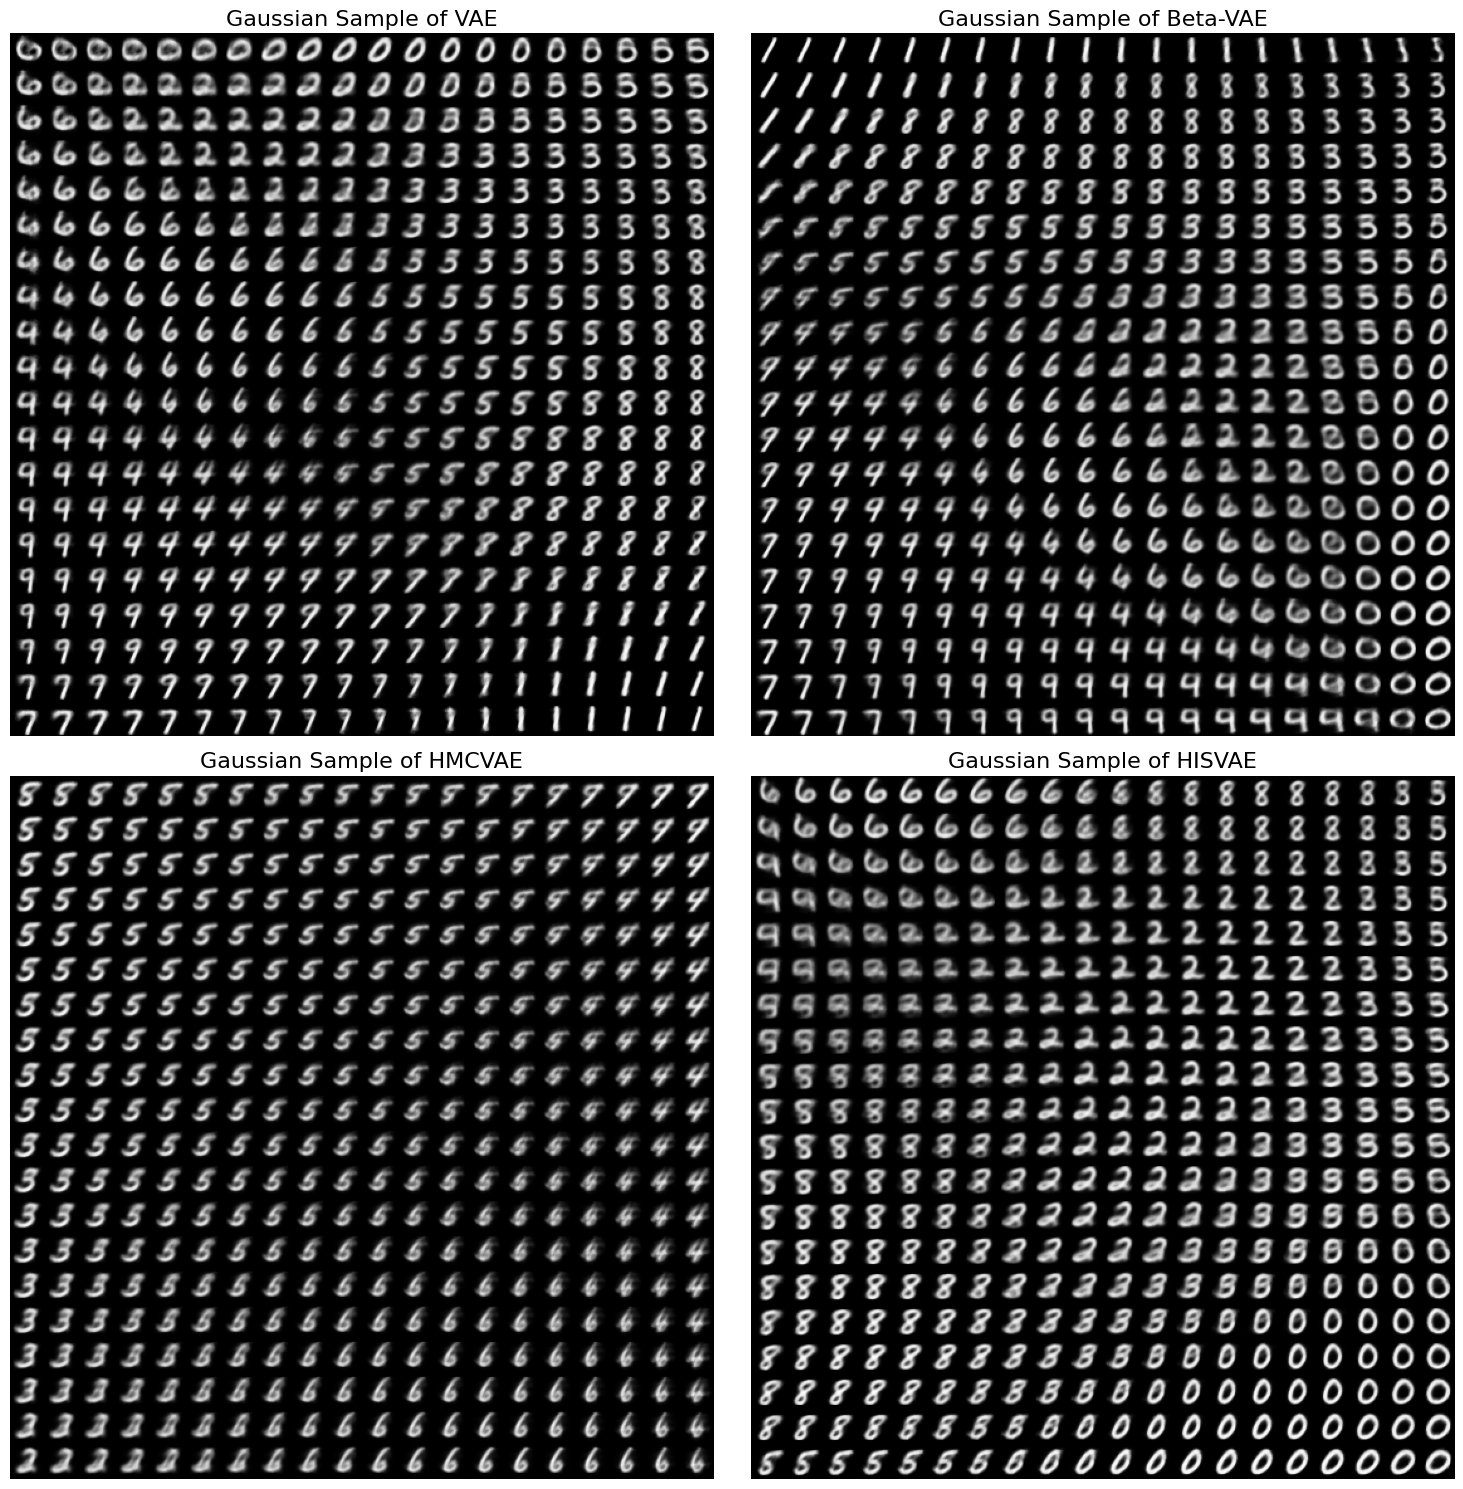

In [56]:
def visualize_latent_grid(models, loader, device):
    """
    Visualize latent space reconstructions for different VAE models,
    each represented as a grid of images reconstructed from latent space samples.

    Parameters:
    - models: Dictionary of (model_name, model_instance) pairs.
    - loader: DataLoader for getting some example data (for dimensionality).
    - device: Compute device (CPU or GPU).
    """
    samples_per_dim = 20
    digit_size = 28
    grid_x = norm.ppf(np.linspace(0.05, 0.95, samples_per_dim))
    grid_y = norm.ppf(np.linspace(0.05, 0.95, samples_per_dim))

    fig, axs = plt.subplots(2, 2, figsize=(15, 15))  # Prepare a 2x2 subplot grid.
    axs = axs.flatten()

    for idx, (name, model) in enumerate(models.items()):
        model.eval()
        figure = np.zeros((digit_size * samples_per_dim, digit_size * samples_per_dim))

        for i, xi in enumerate(grid_x):
            for j, yi in enumerate(grid_y):
                z_sample = torch.tensor([[xi, yi]], dtype=torch.float32).to(device)
                x_decoded = model.decoder(z_sample).cpu().detach().numpy()
                digit = x_decoded.reshape(digit_size, digit_size)
                figure[j * digit_size: (j + 1) * digit_size,
                       i * digit_size: (i + 1) * digit_size] = digit

        axs[idx].imshow(figure, cmap='Greys_r')
        axs[idx].set_title(f'Gaussian Sample of {name}', fontsize=16)
        axs[idx].axis('off')  # Hide axes for better focus on images

    plt.tight_layout()
    plt.show()

# Example setup and function call
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
models = {
    "VAE": vae,
    "Beta-VAE": beta_vae,
    "HMCVAE": hmcvae,
    "HISVAE": hisvae
}
data_loader = test_loader  # Assuming `test_loader` is already defined

visualize_latent_grid(models, data_loader, device)

In [60]:
def calculate_bce_loss(reconstructed_x, x):
    """ Binary Cross Entropy loss for reconstruction. """
    return F.binary_cross_entropy(reconstructed_x, x.view(-1, 784), reduction='sum')

def calculate_kl_divergence(mu, log_var):
    """ KL divergence loss calculation. """
    return -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

def calculate_vae_elbo(reconstructed_x, x, mu, log_var):
    """ Calculate ELBO for VAE or Beta-VAE. """
    bce = calculate_bce_loss(reconstructed_x, x)
    kl_div = calculate_kl_divergence(mu, log_var)
    return -bce - kl_div

def calculate_his_elbo(reconstructed_x, x, mu, log_var, z, p, model):
    """ Calculate a modified ELBO for HISVAE with Hamiltonian dynamics. """
    initial_hamiltonian = model.hamiltonian(z, p, mu, log_var)
    z_new, p_new = model.leapfrog(z, p, mu, log_var)
    final_hamiltonian = model.hamiltonian(z_new, p_new, mu, log_var)
    bce = calculate_bce_loss(reconstructed_x, x)
    delta_hamiltonian = initial_hamiltonian - final_hamiltonian
    return -bce + torch.mean(delta_hamiltonian)  # HIS-modified ELBO

def evaluate_models(models, data_loader, device):
    """ Evaluate multiple models on BCE, KL, and respective ELBOs, handling special cases for HMCVAE and HISVAE. """
    results = {}
    for model_name, model in models.items():
        model.eval()  # Set the model to evaluation mode
        total_bce, total_kl, total_elbo = 0.0, 0.0, 0.0
        with torch.no_grad():
            for data, _ in data_loader:
                data = data.to(device)
                outputs = model(data)

                if len(outputs) == 4:
                    recon_batch, mu, log_var, z = outputs
                else:
                    recon_batch, mu, log_var = outputs[:3]

                bce = calculate_bce_loss(recon_batch, data)
                kl = calculate_kl_divergence(mu, log_var)
                elbo = calculate_vae_elbo(recon_batch, data, mu, log_var)  # Default ELBO calculation

                # Additional calculations for HISVAE
                if 'HISVAE' in model_name:
                    p = torch.randn_like(z)  # Sample initial momenta for HIS
                    elbo = calculate_his_elbo(recon_batch, data, mu, log_var, z, p, model)

                total_bce += bce.item()
                total_kl += kl.item()
                total_elbo += elbo.item()

        # Averaging over all batches
        num_samples = len(data_loader.dataset)
        average_bce = total_bce / num_samples
        average_kl = total_kl / num_samples
        average_elbo = total_elbo / num_samples

        results[model_name] = {
            "Average BCE": average_bce,
            "Average KL Divergence": average_kl,
            "Average ELBO": average_elbo
        }
        print(f"{model_name} -> Average BCE: {average_bce:.4f}, Average KL Divergence: {average_kl:.4f}, Average ELBO: {average_elbo:.4f}")
        model.train()  # Reset to training mode if needed later

    return results

# Example setup and function call
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
models = {
    "VAE": vae,
    "Beta-VAE": beta_vae,
    "HMCVAE": hmcvae,
    "HISVAE": hisvae
}
data_loader = test_loader  # Assuming `test_loader` is already defined

evaluate_models(models, data_loader, device)

VAE -> Average BCE: 142.1509, Average KL Divergence: 6.0286, Average ELBO: -148.1796
Beta-VAE -> Average BCE: 146.5978, Average KL Divergence: 4.1729, Average ELBO: -150.7706
HMCVAE -> Average BCE: 141.2108, Average KL Divergence: 23.4525, Average ELBO: -164.6633
HISVAE -> Average BCE: 139.9480, Average KL Divergence: 19.7474, Average ELBO: -139.9480


{'VAE': {'Average BCE': 142.15093212890625,
  'Average KL Divergence': 6.028645124816895,
  'Average ELBO': -148.17957739257812},
 'Beta-VAE': {'Average BCE': 146.59777026367186,
  'Average KL Divergence': 4.172867314910889,
  'Average ELBO': -150.77063779296876},
 'HMCVAE': {'Average BCE': 141.21077719726563,
  'Average KL Divergence': 23.45247811126709,
  'Average ELBO': -164.66325541992188},
 'HISVAE': {'Average BCE': 139.94795485839845,
  'Average KL Divergence': 19.74735847167969,
  'Average ELBO': -139.9479546386719}}